In [2]:
import numpy as np
import pandas as pd
import sqlite3
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
conn = sqlite3.connect("../db/stocks.db")
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
print(cursor.fetchall())

[('growth_stock',), ('value_stock',), ('inflation_5yr',), ('exchange',), ('CPI',), ('leverage',), ('spending',), ('GDP',), ('treasury_10yr',)]


In [60]:
cmd = '''
SELECT g.Date AS Date,
        g."Adj Close" AS GrowthStock_AdjClose,
        (g."Adj Close" - LAG(g."Adj Close", 1) OVER (ORDER BY g.Date))/ 
                LAG(g."Adj Close", 1) OVER (ORDER BY g.Date) AS GrowthStock_PercentChange,
        
        v."Adj Close" AS ValueStock_AdjClose,
        (v."Adj Close" - LAG(v."Adj Close", 1) OVER (ORDER BY v.Date))/ 
                LAG(v."Adj Close", 1) OVER (ORDER BY v.Date) AS ValueStock_PercentChange,
        
        t."Adj Close" AS Treasury10yr_AdjClose,
        (t."Adj Close" - LAG(t."Adj Close", 1) OVER (ORDER BY t.Date))/ 
                LAG(t."Adj Close", 1) OVER (ORDER BY t.Date) AS Treasury10yr_PercentChange,
        (t."Adj Close" - LAG(t."Adj Close", 1) OVER (ORDER BY t.Date)) AS Treasury10yr_Diff,
        
        e.DEXCAUS AS exchange,
        (e.DEXCAUS - LAG(e.DEXCAUS, 1) OVER (ORDER BY e.Date))/ 
                LAG(e.DEXCAUS, 1) OVER (ORDER BY e.Date) AS exchange_PercentChange,
        (e.DEXCAUS - LAG(e.DEXCAUS, 1) OVER (ORDER BY e.Date)) AS exchange_Diff,
        
        i.T5YIE AS inflation5yr,
        (i.T5YIE - LAG(i.T5YIE, 1) OVER (ORDER BY i.Date))/ 
                LAG(i.T5YIE, 1) OVER (ORDER BY i.Date) AS inflation5yr_PercentChange,
        (i.T5YIE - LAG(i.T5YIE, 1) OVER (ORDER BY i.Date)) AS inflation5yr_Diff,
        
        c.CPIAUCSL_PC1 AS CPI,
        (c.CPIAUCSL_PC1 - LAG(c.CPIAUCSL_PC1, 1) OVER (ORDER BY c.Date))/ 
                LAG(c.CPIAUCSL_PC1, 1) OVER (ORDER BY c.Date) AS CPI_PercentChange,
        (c.CPIAUCSL_PC1 - LAG(c.CPIAUCSL_PC1, 1) OVER (ORDER BY c.Date)) AS CPI_Diff
        
FROM growth_stock g
LEFT JOIN value_stock v
ON g.Date = v.Date
LEFT JOIN treasury_10yr t
ON g.Date = t.Date
LEFT JOIN exchange e
ON g.Date = e.Date
LEFT JOIN inflation_5yr i
ON g.Date = i.Date
LEFT JOIN CPI c
ON g.Date = c.Date
'''

df = pd.read_sql_query(cmd, conn)
df.head()

Date  GrowthStock_AdjClose  GrowthStock_PercentChange  \
0  2000-05-26             15.213005                        NaN   
1  2000-05-30             15.844181                   0.041489   
2  2000-05-31             15.806020                  -0.002409   
3  2000-06-01             16.040890                   0.014860   
4  2000-06-02             16.569317                   0.032942   

   ValueStock_AdjClose  ValueStock_PercentChange  Treasury10yr_AdjClose  \
0            36.438076                       NaN                  6.320   
1            36.994823                  0.015279                  6.367   
2            37.273205                  0.007525                  6.285   
3            37.733952                  0.012361                  6.195   
4            38.261909                  0.013992                  6.148   

   Treasury10yr_PercentChange  Treasury10yr_Diff exchange  \
0                         NaN                NaN   1.5045   
1                    0.007437              0.047   1.5036   
2                   -0.012879             -0.082   1.4977   
3                   -0.014320             -0.090   1.4910   
4                   -0.007587             -0.047   1.4785   

   exchange_PercentChange  exchange_Diff inflation5yr  \
0                     NaN            NaN         None   
1               -0.000598        -0.0009         None   
2               -0.003924        -0.0059         None   
3               -0.004474        -0.0067         None   
4               -0.008384        -0.0125         None   

   inflation5yr_PercentChange  inflation5yr_Diff      CPI  CPI_PercentChange  \
0                         NaN                NaN      NaN                NaN   
1                         NaN                NaN      NaN                NaN   
2                         NaN                NaN      NaN                NaN   
3                         NaN                NaN  3.73494                NaN   
4                         NaN                NaN      NaN                NaN   

   CPI_Diff  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN

In [61]:
df['Date'] = pd.to_datetime(df['Date'])

In [62]:
df.isna().sum()

Date                             0
GrowthStock_AdjClose             0
GrowthStock_PercentChange        1
ValueStock_AdjClose              0
ValueStock_PercentChange         1
Treasury10yr_AdjClose            7
Treasury10yr_PercentChange      13
Treasury10yr_Diff               13
exchange                         1
exchange_PercentChange          53
exchange_Diff                    2
inflation5yr                   651
inflation5yr_PercentChange     689
inflation5yr_Diff              652
CPI                           5294
CPI_PercentChange             5295
CPI_Diff                      5295
dtype: int64

In [63]:
df['CPI'] = df.CPI.fillna(method = 'ffill', limit = 30)
df['CPI_PercentChange'] = df.CPI_PercentChange.fillna(method = 'ffill', limit = 30)
df['CPI_Diff'] = df.CPI_Diff.fillna(method = 'ffill', limit = 30)

In [64]:
df.isna().sum()

Date                             0
GrowthStock_AdjClose             0
GrowthStock_PercentChange        1
ValueStock_AdjClose              0
ValueStock_PercentChange         1
Treasury10yr_AdjClose            7
Treasury10yr_PercentChange      13
Treasury10yr_Diff               13
exchange                         1
exchange_PercentChange          53
exchange_Diff                    2
inflation5yr                   651
inflation5yr_PercentChange     689
inflation5yr_Diff              652
CPI                           1191
CPI_PercentChange             1222
CPI_Diff                      1222
dtype: int64

In [72]:
df = df.dropna()

## EDA and Visualizations

In [57]:
def compare_indices(data, col_A, col_B):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
#     fig.suptitle('Pokemon Stats by Generation')

    sns.lineplot(ax=axes[0], data=data, x='Date', y=col_A)
    sns.lineplot(ax=axes[0], data=data, x='Date', y=col_B)
    sns.scatterplot(ax=axes[1], x = col_A, y = col_B, size = 0.1, data = data)

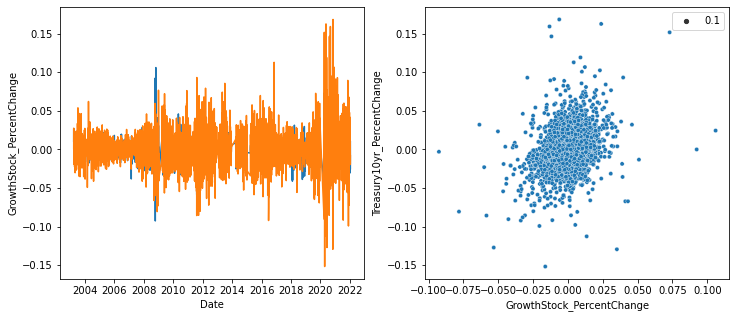

In [58]:
compare_indices(df, 'GrowthStock_PercentChange', 'Treasury10yr_PercentChange')

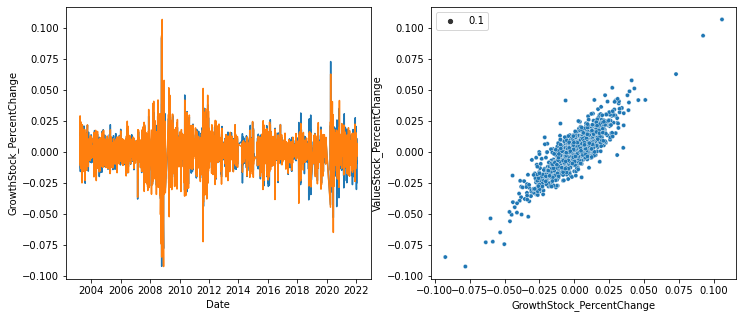

In [59]:
compare_indices(df, 'GrowthStock_PercentChange', 'ValueStock_PercentChange')

<AxesSubplot:xlabel='Date', ylabel='GrowthStock_AdjClose'>

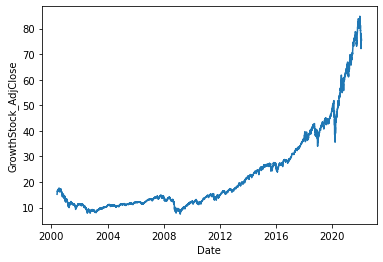

In [65]:
sns.lineplot(y='GrowthStock_AdjClose', x='Date', data = df)

<AxesSubplot:xlabel='Date', ylabel='GrowthStock_PercentChange'>

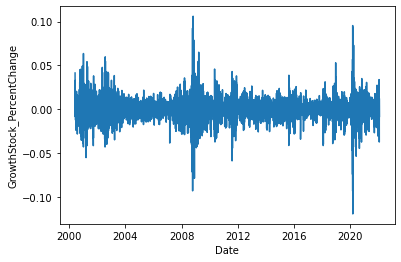

In [66]:
sns.lineplot(y='GrowthStock_PercentChange', x='Date', data = df)

<AxesSubplot:xlabel='Date', ylabel='Treasury10yr_AdjClose'>

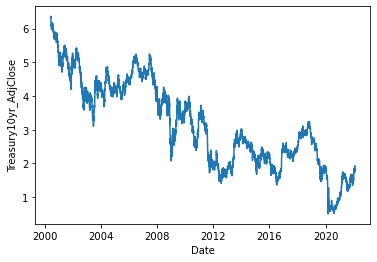

In [67]:
sns.lineplot(y='Treasury10yr_AdjClose', x='Date', data = df)

<AxesSubplot:xlabel='Date', ylabel='Treasury10yr_Diff'>

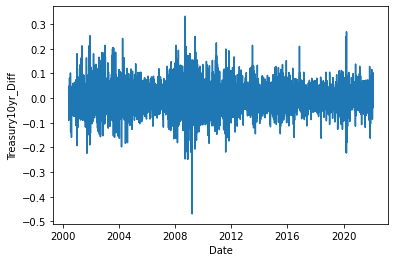

In [68]:
sns.lineplot(y='Treasury10yr_Diff', x='Date', data = df)

<AxesSubplot:xlabel='Treasury10yr_Diff', ylabel='GrowthStock_PercentChange'>

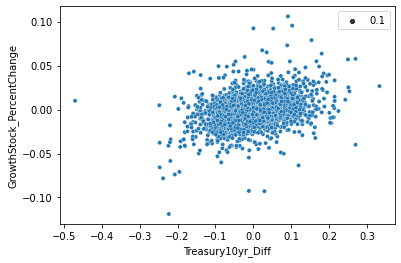

In [69]:
plt.figure(figsize = (6,4))
sns.scatterplot(x = 'Treasury10yr_Diff', 
                y = 'GrowthStock_PercentChange',
                size = 0.1,
                data = df)

## Linear Regression

In [70]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import OLSInfluence

In [73]:
X = df.Treasury10yr_PercentChange
y = df.GrowthStock_PercentChange
X = sm.add_constant(X)

model = OLS(y, X)
results = model.fit()

cooks_distance = OLSInfluence(results).cooks_distance[0]
to_remove = cooks_distance >= 4/(X.shape[0]-1)

In [74]:
X = X[~to_remove]
y = y[~to_remove]

model = OLS(y, X)
results = model.fit()

In [75]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     GrowthStock_PercentChange   R-squared:                       0.103
Model:                                   OLS   Adj. R-squared:                  0.103
Method:                        Least Squares   F-statistic:                     398.7
Date:                       Thu, 24 Feb 2022   Prob (F-statistic):           4.58e-84
Time:                               00:25:37   Log-Likelihood:                 12059.
No. Observations:                       3477   AIC:                        -2.411e+04
Df Residuals:                           3475   BIC:                        -2.410e+04
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0009      0.000      7.225      0.000       0.001       0.001
Treasury10yr_PercentChange     0.1305      0.007     19.968      0.000       0.118       0.143
==============================================================================
Omnibus:                       42.411   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.605
Skew:                          -0.109   Prob(JB):                     5.67e-15
Kurtosis:                       3.637   Cond. No.                         51.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

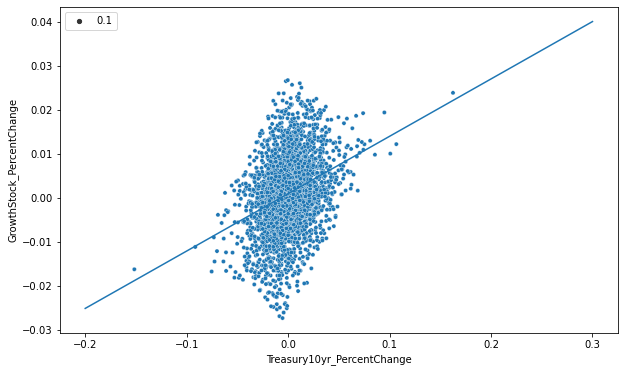

In [76]:
plt.figure(figsize = (10,6))

sns.scatterplot(x = X.iloc[:,1], 
                y = y,
                size = 0.1,
                data = df)

x0 = np.linspace(-0.2,0.3)
y0 = results.params[0] + results.params[1] * x0
plt.plot(x0, y0)

In [77]:
X = df.Treasury10yr_Diff
y = df.GrowthStock_PercentChange
X = sm.add_constant(X)

model = OLS(y, X)
results = model.fit()

cooks_distance = OLSInfluence(results).cooks_distance[0]
to_remove = cooks_distance >= 4/(X.shape[0]-1)

In [78]:
X = X[~to_remove]
y = y[~to_remove]

model = OLS(y, X)
results = model.fit()

In [79]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     GrowthStock_PercentChange   R-squared:                       0.090
Model:                                   OLS   Adj. R-squared:                  0.090
Method:                        Least Squares   F-statistic:                     343.4
Date:                       Thu, 24 Feb 2022   Prob (F-statistic):           3.51e-73
Time:                               00:25:49   Log-Likelihood:                 12057.
No. Observations:                       3483   AIC:                        -2.411e+04
Df Residuals:                           3481   BIC:                        -2.410e+04
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0010      0.000      7.751      0.000       0.001       0.001
Treasury10yr_Diff     0.0510      0.003     18.530      0.000       0.046       0.056
==============================================================================
Omnibus:                       41.403   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.878
Skew:                          -0.098   Prob(JB):                     8.17e-15
Kurtosis:                       3.639   Cond. No.                         21.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

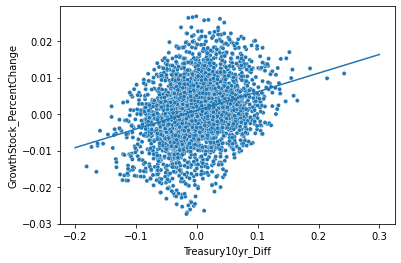

In [80]:
plt.figure(figsize = (6,4))

sns.scatterplot(x = X.iloc[:,1], 
                y = y,
                size = 0.01,
                data = df,
               legend = False)

x0 = np.linspace(-0.2,0.3)
y0 = results.params[0] + results.params[1] * x0
plt.plot(x0, y0)

In [47]:
IVW.Date = pd.to_datetime(IVW.Date)
IVW['Diff'] = (IVW['Adj Close'] - IVW['Adj Close'].shift(1))
IVW['Percent_Change'] = (IVW['Adj Close'] - IVW['Adj Close'].shift(1))/IVW['Adj Close'].shift(1)

<AxesSubplot:xlabel='Date', ylabel='Adj Close'>

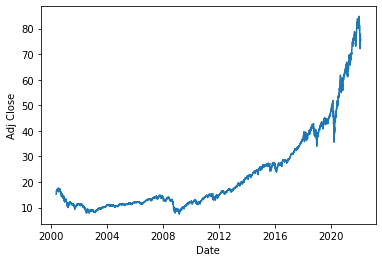

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition
Adj_close = IVW['Adj Close']
Adj_close.index = df.Date.apply(lambda x: datetime.fromisoformat(x))
Adj_close.name = "Adj Close"
decomp = seasonal_decompose(Adj_close)

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [ ]:
# Plot decomposition
decomp.plot()
plt.tight_layout()
plt.xlabel('year')

## Neuron Network
#### Simple Regression Model

In [23]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np

In [9]:
df.head()

Date  GrowthStock_AdjClose  GrowthStock_PercentChange  \
1 2003-05-01              9.085768                   0.056089   
2 2003-07-01              9.670133                   0.064317   
3 2003-08-01              9.606513                  -0.006579   
4 2003-10-01             10.052144                   0.046388   
5 2003-12-01             10.467760                   0.041346   

   ValueStock_AdjClose  ValueStock_PercentChange  Treasury10yr_AdjClose  \
1            28.422388                  0.079159                  3.856   
2            31.000845                  0.090719                  3.549   
3            31.233463                  0.007504                  4.415   
4            32.274162                  0.033320                  3.932   
5            34.494129                  0.068785                  4.392   

   Treasury10yr_PercentChange  Treasury10yr_Diff exchange  \
1                    0.007578              0.029   1.4191   
2                   -0.079616             -0.307   1.3492   
3                    0.244012              0.866   1.3960   
4                   -0.109400             -0.483   1.3481   
5                    0.116989              0.460   1.3023   

   exchange_PercentChange  exchange_Diff inflation5yr  \
1               -0.036527        -0.0538         1.30   
2               -0.049257        -0.0699         1.45   
3                0.034687         0.0468         1.75   
4               -0.034312        -0.0479         1.84   
5               -0.033974        -0.0458         2.04   

   inflation5yr_PercentChange  inflation5yr_Diff      CPI  CPI_PercentChange  \
1                   -0.207317              -0.34  1.89415          -0.129178   
2                    0.115385               0.15  2.05556           0.085215   
3                    0.206897               0.30  2.21607           0.078086   
4                    0.051429               0.09  2.04194          -0.078576   
5                    0.108696               0.20  2.03520          -0.003301   

   CPI_Diff  
1  -0.28098  
2   0.16141  
3   0.16051  
4  -0.17413  
5  -0.00674

In [45]:
y = df["GrowthStock_PercentChange"]
X = df[["Treasury10yr_PercentChange", "exchange_PercentChange", "inflation5yr"]]

# convert to np array
X = np.array(X, dtype = np.float32)
y = np.array(y, dtype = np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [46]:
# normalize the dataset
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [62]:
# model training 

# input layer
input_layer = Input(shape=(X.shape[1],))
dense_layer_1 = Dense(300, activation='relu')(input_layer)
dense_layer_2 = Dense(300, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(300, activation='relu')(dense_layer_2)
# output layer
output = Dense(1)(dense_layer_3)

model1 = Model(inputs=input_layer, outputs=output)
model1.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

In [56]:
model1.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_28 (Dense)             (None, 300)               1200      
_________________________________________________________________
dense_29 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_30 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 301       
Total params: 182,101
Trainable params: 182,101
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = model1.fit(X_train, y_train, batch_size=2, epochs=100, verbose=1, validation_split=0.2)

Train on 80 samples, validate on 21 samples
Epoch 1/100
80/80 [==============================] - 2s 21ms/sample - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 2/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 3/100
80/80 [==============================] - 0s 4ms/sample - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 4/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 5/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 6/100
80/80 [==============================] - 0s 5ms/sample - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0025 - val_mean

Epoch 97/100
80/80 [==============================] - 0s 6ms/sample - loss: 7.1370e-04 - mean_squared_error: 7.1370e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 98/100
80/80 [==============================] - 0s 6ms/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 99/100
80/80 [==============================] - 0s 5ms/sample - loss: 5.2409e-04 - mean_squared_error: 5.2409e-04 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 100/100
80/80 [==============================] - 0s 5ms/sample - loss: 3.7715e-04 - mean_squared_error: 3.7715e-04 - val_loss: 0.0060 - val_mean_squared_error: 0.0060


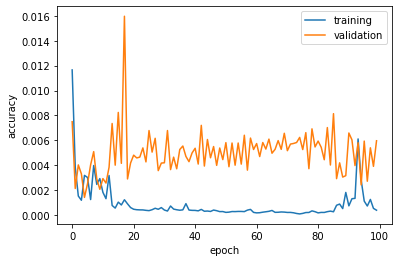

In [58]:
# plot the minimimal loss
plt.plot(history.history["mean_squared_error"], label = "training")
plt.plot(history.history["val_mean_squared_error"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

In [64]:
# model evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_train = model1.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred = model1.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred)))

0.07519727
0.06663189
